In [1]:
import numpy as np
import pandas as pd
pd.options.display.precision = 15

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
from pylab import plot, show, title, xlabel, ylabel, subplot, rcParams
rcParams['figure.figsize'] = 18, 8
import seaborn as sns

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

from tqdm import tqdm
from scipy import signal
import statsmodels.api as sm
import itertools

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge, RidgeCV
import xgboost as xgb

import time
import datetime

import gc

filepath = 'D:/Kaggle/LANL_earthquake/'

# Load and check the train data

In [5]:
%%time
train = pd.read_csv(filepath + 'train.csv',
                    dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

Wall time: 18min 38s


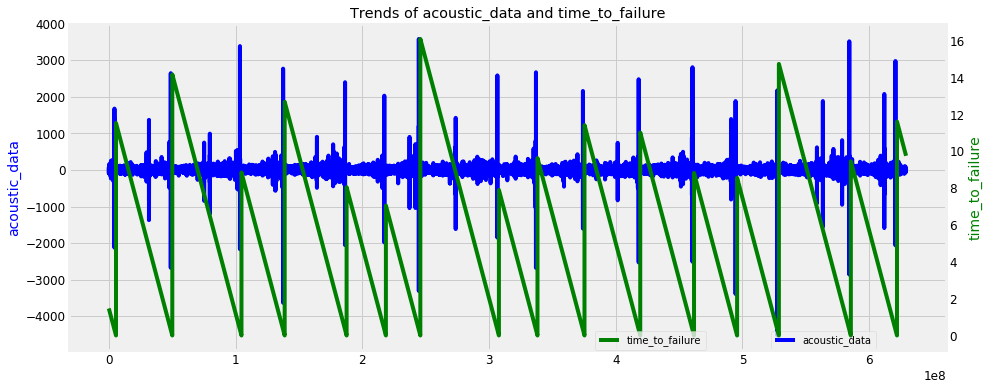

In [3]:
# check the data as general
train_acoustic_data_small = train.acoustic_data[::10] # take every 10 sample for speed
train_time_to_failure_small = train.time_to_failure[::10]

fig, ax1 = plt.subplots(figsize=(14, 6))
plt.title("Trends of acoustic_data and time_to_failure")
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'], loc=(0.8, -0.00001))
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.6, -0.00001))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

Wee see that earthquake happens periodically. Note that there are some amplitude jumps which are not considered as earthquake, presumably because they are not big enough.

time_to_failure data has some delay with the exact earthquake event from acoustic_data. This happens to all the earthquakes.

# More assessment on the training data

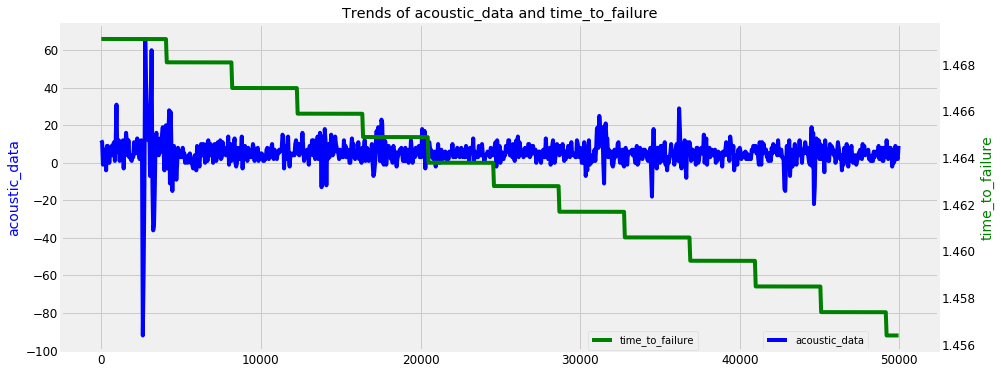

In [8]:
# check small chunk of data
train_acoustic_data_small = train.acoustic_data[:50000][::50]
train_time_to_failure_small = train.time_to_failure[:50000][::50]

fig, ax1 = plt.subplots(figsize=(14, 6))
plt.title("Trends of acoustic_data and time_to_failure")
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'], loc=(0.8, -0.00001))
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.6, -0.00001))
plt.grid(False)

del train_acoustic_data_small, train_time_to_failure_small

dt = 0.001 # dt between blocks: 1 ms

time_to_failure seems to be divided by big jumps. Time jump between each block is around ~1 ms.

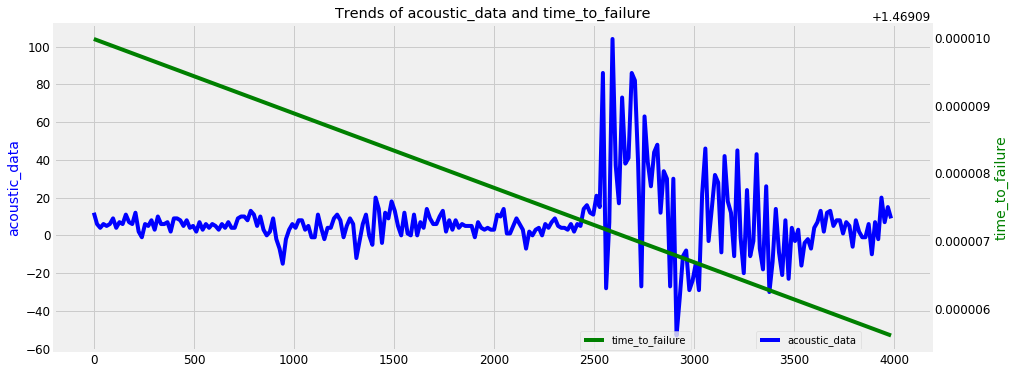

In [5]:
# even smaller chunk of data (within one block)
train_acoustic_data_small = train.acoustic_data[:1000][::4]
train_time_to_failure_small = train.time_to_failure[:1000][::4]

fig, ax1 = plt.subplots(figsize=(14, 6))
plt.title("Trends of acoustic_data and time_to_failure")
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'], loc=(0.8, -0.00001))
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.6, -0.00001))
plt.grid(False)

del train_acoustic_data_small, train_time_to_failure_small

In [ ]:
dt_inblock = train.time_to_failure[0]-train.time_to_failure[1] # dt within block. 1 block: 4095 samples
dt_inblock_res = dt_inblock*4 # resampled dt within block, take 1 each out of 4 sample. Thus, 1 block: 1024 samples.
Fs_inblock_res = 1/dt_inblock_res # sampling rate within a block after resampled

time_to_failure within a block gradually decrease, with time increment of dt_inblock

# Frequency analysis of earthquake and non-earthquake

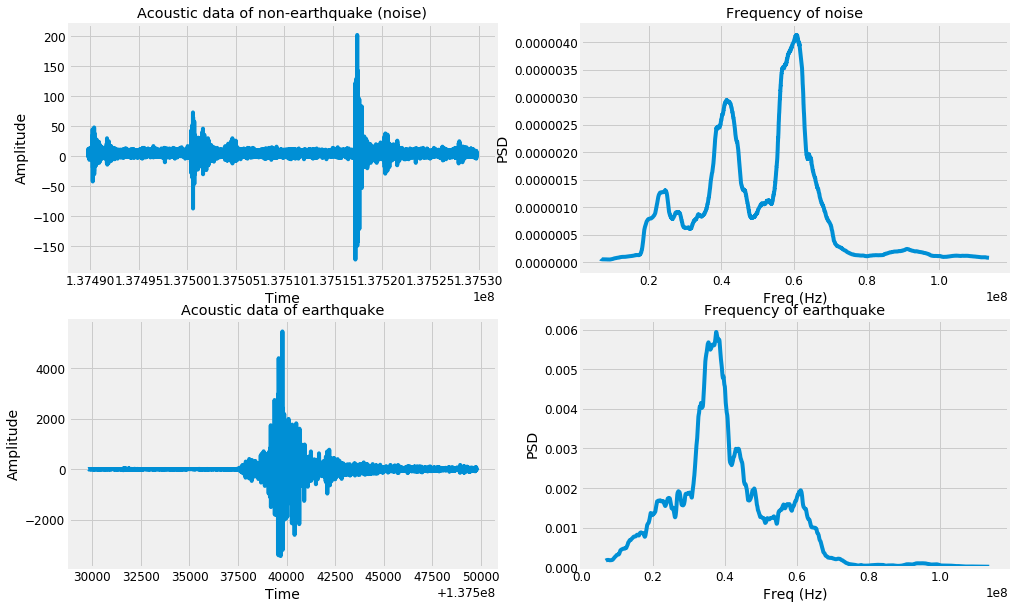

In [73]:
# frequency analysis of non-earthquake

earthquake_idx = train[train.acoustic_data.abs() == train.acoustic_data.abs().max()].index[0] #index where the biggest earthquake happens

data = train.acoustic_data[earthquake_idx-50000:earthquake_idx-10000][::4] # based on frequency nyquist, data can be down-sampled by a quarter
f, P_den = signal.periodogram(data, Fs_inblock_res, nfft=2*len(data)) # frequency spectrum
P_den = pd.Series(P_den).rolling(window=600).mean() # smoothened the spectra density

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.title('Acoustic data of non-earthquake (noise)')
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.subplot(2,2,2)
plt.title("Frequency of noise")
plt.plot(f, P_den)
plt.xlabel('Freq (Hz)')
plt.ylabel('PSD')

# frequency of only the earthquake
data = train.acoustic_data[earthquake_idx-10000:earthquake_idx+10000][::4] # based on frequency nyquist, data can be down-sampled by a quarter
f, P_den = signal.periodogram(data, Fs_inblock_res, nfft=2*len(data)) # frequency spectrum
P_den = pd.Series(P_den).rolling(window=300).mean() # smoothened the spectra density

plt.subplot(2,2,3)
plt.title('Acoustic data of earthquake')
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.subplot(2,2,4)
plt.title('Frequency of earthquake')
plt.plot(f, P_den)
plt.xlabel('Freq (Hz)')
plt.ylabel('PSD')
plt.ylim(bottom=0)
plt.xlim(left=0)
show()

earthquake_freq = f[P_den == P_den.max()] # peak frequency of earthquake

del data, f, P_den

At least for this particular earthquake sample, the peak/dominant frequency is difference with the noise (not earthquake).
The other obvious difference is the PSD amplitude.

From this graph we resample the acoustic data, taking 1 for every 4 sample, without losing information/signal nor aliasing.

# Resample data for efficiency

In [6]:
# resample/decimate data based in nyquist frequency. Reduces samples without losing signal information.
train = train[::4]# take 1 for every 4 samples

print('Data shape:', train.shape)
train.head()

Data shape: (157286370, 2)


,acoustic_data,time_to_failure
0,12,1.4690999832
4,8,1.4690999788
8,-5,1.4690999744
12,2,1.4690999700
16,6,1.4690999656


# Asses the test data

In [11]:
# check the test data, then resample it
test = pd.read_csv(filepath + 'test/seg_00a37e.csv',
                    dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
test = test[::4] # apply the same resampling parameter as the train data
print(test.head(), test.shape)

    acoustic_data
0              -2
4               8
8               8
12              2
16              5 (37500, 1)


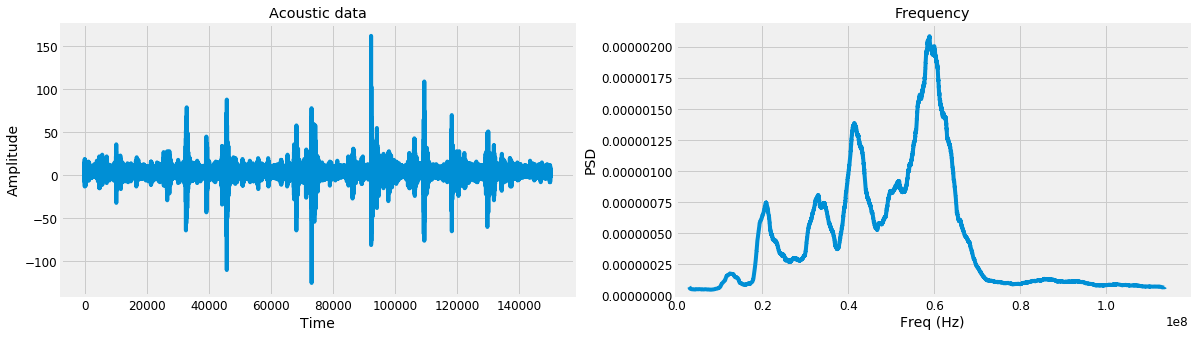

In [12]:
# frequency analysis of test data
data = test.acoustic_data
f, P_den = signal.periodogram(data, Fs_inblock_res, nfft=2*len(data)) # frequency spectrum
P_den = pd.Series(P_den).rolling(window=1000).mean() # smoothened the spectra density

plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.title('Acoustic data')
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.subplot(1,2,2)
plt.title('Frequency')
plt.plot(f, P_den)
plt.xlabel('Freq (Hz)')
plt.ylabel('PSD')
plt.ylim(bottom=0)
plt.xlim(left=0)
show()

del data, f, P_den

# Standard feature engineering, using statistics and frequency content

In [7]:
# features engineering, with training data
rows_block = 37500 # use 37500 to mimic the test data (after resample)
num_blocks = int(len(train)/rows_block) # total length divided by number of samples per block.

dt_inblock_res = train.time_to_failure[0]-train.time_to_failure[4] # resampled dt within block, take 1 each out of 4 sample. Thus, 1 block: 1024 samples.
Fs_inblock_res = 1/dt_inblock_res # sampling rate within a block after resampled

y_tr = pd.DataFrame(index=range(num_blocks), dtype=np.float64,
                       columns=['time_to_failure'])

X_tr  = pd.DataFrame(index=range(num_blocks), dtype=np.float64,
                       columns=[
                                'mean',
                                'abs_mean', 'std', 'max', 'abs_min', 'abs_max', 'abs_med', 'var',
                                'q01', 'q05', 'q95', 'q99',
                                'max_min_diff', 'mean_change_abs',
                                'peak_freq', 'max_spect', 'mean_spect'])


In [8]:
# QC before running feature generation
print('Total no. of blocks:', num_blocks)
print('Number of sample per block:', rows_block)
print('Total sample:', len(train), '(Decimated)')
print('Total sample / No. sample per block:', len(train)/rows_block)
print('Sampling rate', Fs_inblock_res)
print('X_tr shape:', X_tr.shape)


Total no. of blocks: 4194
Number of sample per block: 37500
Total sample: 157286370 (Decimated)
Total sample / No. sample per block: 4194.3032
Sampling rate 227272719.93734387
X_tr shape: (4194, 17)


# Feature generation using training data

In [9]:
# fill training data with features value for each block
for block in tqdm(range(num_blocks)): 
    seg = train[block*rows_block:block*rows_block+rows_block]
    x = seg.acoustic_data.values
    y = seg.time_to_failure.values[-1] # pick the last time_to_failure sample. 
                                       # meaning, each delta y for each block should be 1 ms
    
    y_tr.loc[block, 'time_to_failure'] = y
    
    X_tr.loc[block, 'mean'] = x.mean()
    X_tr.loc[block, 'abs_mean'] = np.abs(x).mean()
    X_tr.loc[block, 'std'] = x.std()
    X_tr.loc[block, 'max'] = x.max()
    X_tr.loc[block, 'abs_min'] = np.abs(x.min())
    X_tr.loc[block, 'abs_med'] = np.median(np.abs(x))
    X_tr.loc[block, 'var'] = x.var()
    X_tr.loc[block, 'q01'] = np.quantile(x,0.01)
    X_tr.loc[block, 'q05'] = np.quantile(x,0.05)
    X_tr.loc[block, 'q95'] = np.quantile(x,0.95)
    X_tr.loc[block, 'q99'] = np.quantile(x,0.99)
    X_tr.loc[block, 'max_min_diff'] = x.max()-x.min()
    X_tr.loc[block, 'mean_change_abs'] = np.mean(np.abs(np.diff(x)))
    X_tr.loc[block, 'abs_max'] = np.abs(x).max()
  
    f_tr, P_den_tr = signal.periodogram(x, Fs_inblock_res, nfft=2*len(x)) # frequency spectrum
    P_den_tr = pd.Series(P_den_tr).rolling(window=1000).mean() # smoothened the spectra density
    
    X_tr.loc[block, 'peak_freq'] = np.float64(f_tr[P_den_tr == P_den_tr.max()])/1e5 # down-scaled
    X_tr.loc[block, 'max_spect'] = P_den_tr.max()*1e9 # up-scaled
    X_tr.loc[block, 'mean_spect'] = P_den_tr.mean()*1e9 #up-scaled        

100%|██████████████████████████████████████████████████████████████████████████████| 4194/4194 [01:19<00:00, 53.27it/s]


In [10]:
X_tr.head()

,mean,abs_mean,std,max,abs_min,abs_max,abs_med,var,q01,q05,q95,q99,max_min_diff,mean_change_abs,peak_freq,max_spect,mean_spect
0,4.890186666666667,5.578080000000000,5.095074192965419,104.0,92.0,104.0,5.0,25.959781031822221,-8.0,-2.0,12.0,18.0,196.0,4.471265900424012,577.090890464903509,1558.555235543268736,232.367643385915471
1,4.730560000000000,5.743520000000000,6.596636674831601,181.0,149.0,181.0,5.0,43.515615419733329,-11.0,-2.0,12.0,21.0,330.0,4.829408784234246,602.121192687336247,2872.385751766959402,391.387694731101192
2,4.917626666666667,6.153946666666666,6.966993706084584,129.0,100.0,129.0,5.0,48.539001300622211,-15.0,-3.0,13.0,25.0,229.0,5.252913411024294,577.606041963428083,2724.572132788871841,436.566004349096033
3,4.892480000000000,5.932426666666666,6.922825009796699,191.0,199.0,199.0,5.0,47.925506116266668,-12.0,-2.0,12.0,22.0,390.0,4.869623189951732,600.818162426362164,3651.566969037567560,431.076732345753669
4,4.911333333333333,6.116293333333333,7.324887591098052,145.0,125.0,145.0,5.0,53.653978222222221,-15.0,-2.0,12.0,26.0,270.0,4.917411130963492,215.090902148702213,2347.093065401123567,483.020064733801803


## Check feature correlation with time_to_failure

In [11]:
np.abs(X_tr.corrwith(y_tr['time_to_failure'])).sort_values(ascending=False)

q95                0.425076272165485
q05                0.413969846111456
mean_change_abs    0.364060812297380
q99                0.303110176450818
q01                0.302649016262719
abs_mean           0.286916823189557
abs_med            0.278202255557742
std                0.217090774414275
abs_min            0.193258656725430
max_min_diff       0.192693469837233
max                0.188396308017959
abs_max            0.187664786152081
mean_spect         0.105186788568994
var                0.105173406621529
max_spect          0.104238589150513
peak_freq          0.092496959869490
mean               0.031850635125244
dtype: float64

We see that mean feature has least correlation with time_to_failure. This is because in seismic data (in which the amplitude is around zero), the mean would be somewhere around zero. Taking out the mean would not affect the prediction substantially.

In [13]:
# Scaling
scaler = StandardScaler()
scaler.fit(X_tr)
X_train_scaled = pd.DataFrame(scaler.transform(X_tr), columns=X_tr.columns)

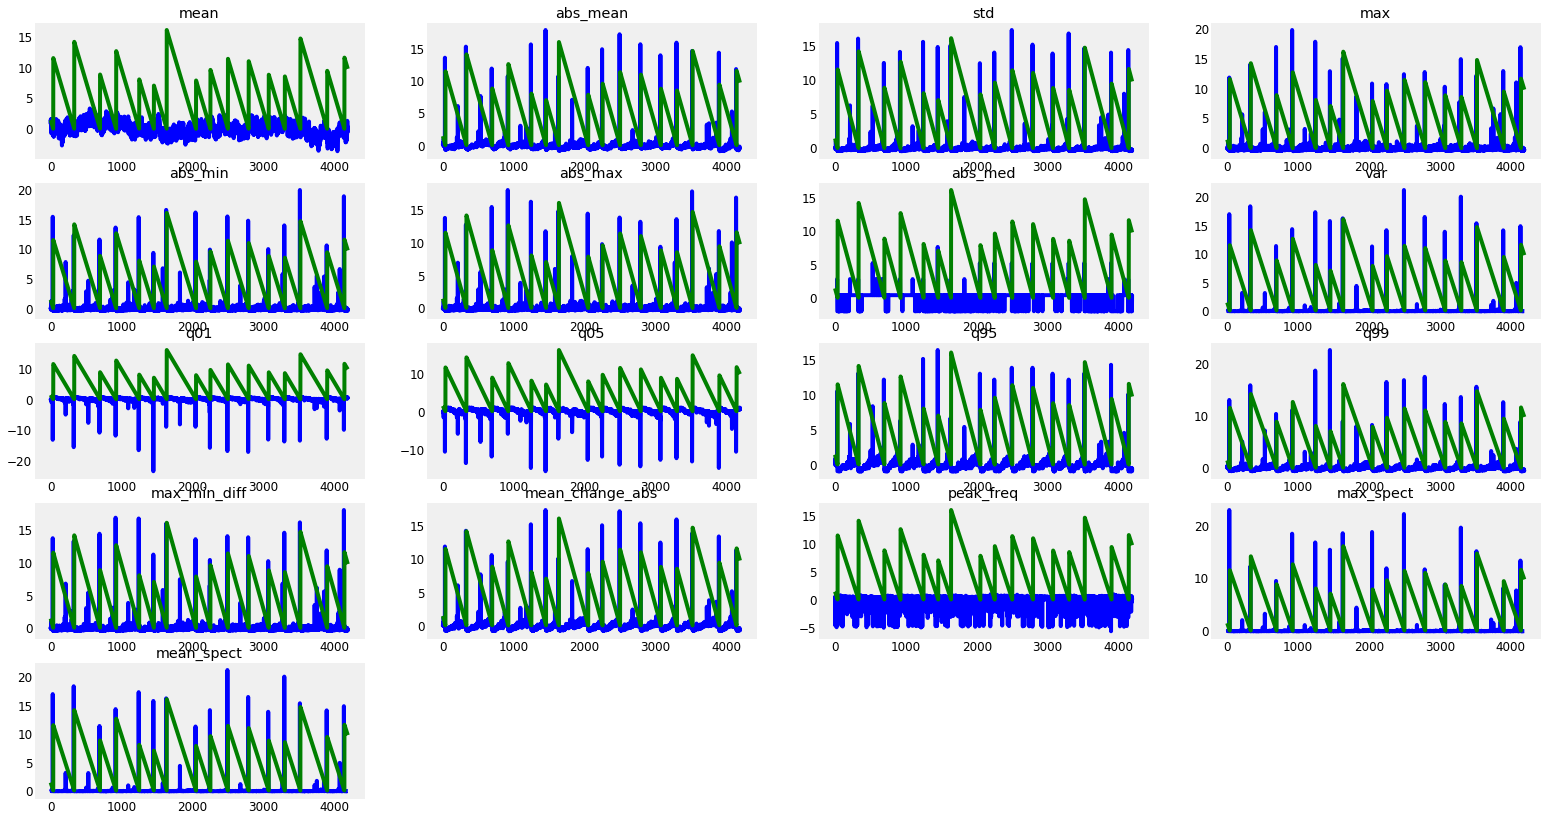

In [14]:
# plot features and its relation with target prediction (time_to_failure)

plt.figure(figsize=(24, 26))
for i, col in enumerate(X_train_scaled.columns):
    plt.subplot(9, 4, i + 1)
    plt.plot(X_train_scaled[col], color='blue')
    plt.title(col)
    ax1.set_ylabel(col, color='b')
    ax2 = ax1.twinx()
    plt.plot(y_tr, color='g')
    ax2.set_ylabel('time_to_failure', color='g')
    plt.grid(False)

We can also see visually from above graph, mean and peak_freq has less correlation with time_to_failure data.

# Feature generation in testing data

In [15]:
submission = pd.read_csv(filepath + 'sample_submission.csv', index_col='seg_id') # take the seg_id
X_ts = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=submission.index) # add X_tr column

# generate test feature value
for i, seg_id in enumerate(tqdm(X_ts.index)):
    seg = pd.read_csv(filepath + '/test/' + seg_id + '.csv')
    seg = seg[::4] # decimate      
    x = seg.acoustic_data.values
    
    X_ts.loc[seg_id, 'mean'] = x.mean()
    X_ts.loc[seg_id, 'abs_mean'] = np.abs(x).mean()
    X_ts.loc[seg_id, 'std'] = x.std()
    X_ts.loc[seg_id, 'max'] = x.max()
    X_ts.loc[seg_id, 'abs_min'] = np.abs(x.min())
    X_ts.loc[seg_id, 'abs_med'] = np.median(np.abs(x))
    X_ts.loc[seg_id, 'var'] = x.var()
    X_ts.loc[seg_id, 'q01'] = np.quantile(x,0.01)
    X_ts.loc[seg_id, 'q05'] = np.quantile(x,0.05)
    X_ts.loc[seg_id, 'q95'] = np.quantile(x,0.95)
    X_ts.loc[seg_id, 'q99'] = np.quantile(x,0.99)
    X_ts.loc[seg_id, 'max_min_diff'] = x.max()-x.min()
    X_ts.loc[seg_id, 'mean_change_abs'] = np.mean(np.abs(np.diff(x)))    
    X_ts.loc[seg_id, 'abs_max'] = np.abs(x).max()
    
    f_ts, P_den_ts = signal.periodogram(x, Fs_inblock_res, nfft=2*len(x)) # frequency spectrum
    P_den_ts = pd.Series(P_den_ts).rolling(window=1000).mean() # smoothened the spectra density
    
    X_ts.loc[seg_id, 'peak_freq'] = np.float64(f_ts[P_den_ts == P_den_ts.max()])/1e5 # down-scaled
    X_ts.loc[seg_id, 'max_spect'] = P_den_ts.max()*1e9 #up-scaled
    X_ts.loc[seg_id, 'mean_spect'] = P_den_ts.mean()*1e9 #up-scaled


100%|██████████████████████████████████████████████████████████████████████████████| 2624/2624 [12:06<00:00,  5.25it/s]


In [26]:
X_ts.head()

,mean,abs_mean,std,max,abs_min,abs_max,abs_med,var,q01,q05,q95,q99,max_min_diff,mean_change_abs,peak_freq,max_spect,mean_spect
seg_id,,,,,,,,,,,,,,,,,
seg_00030f,4.485546666666667,5.229760000000000,4.889343967700461,115.0,75.0,115.0,5.0,23.905684434488887,-9.0,-2.0,11.0,18.0,190.0,4.406464172377930,592.818162684567710,954.397279180887381,213.983334573118697
seg_0012b5,4.178560000000000,5.204853333333333,5.923459264630199,140.0,140.0,140.0,4.0,35.087369659733334,-12.0,-2.0,11.0,20.0,280.0,4.624256646843916,594.484829297441593,1669.598508018012353,315.084700337662412
seg_00184e,4.615120000000000,5.601466666666667,6.944768826409319,241.0,193.0,241.0,5.0,48.229814052266661,-11.0,-2.0,11.0,20.0,434.0,4.627163391023760,352.303018932207976,2626.157844924190158,433.748055744022849
seg_003339,4.532906666666666,4.968533333333333,4.116264951541493,81.0,81.0,81.0,5.0,16.943637151288886,-5.0,-1.0,10.0,14.0,162.0,3.728739433051548,601.121192719611940,614.086826797305321,151.146992762706219
seg_0042cc,4.129760000000000,5.071466666666667,5.794693176438824,177.0,139.0,177.0,4.0,33.578469009066673,-10.0,-2.0,10.0,19.0,316.0,4.432838209018907,587.272708318096420,2203.883824802649542,301.327239262200180


In [18]:
#  scale test data
X_test_scaled = pd.DataFrame(scaler.transform(X_ts), columns=X_ts.columns)

# Model prediction

In [19]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

def train_model(X=X_train_scaled, X_test=X_test_scaled, y=y_tr, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=10000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_tr.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_tr.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
            
        if model_type == 'rcv':
            model = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_absolute_error', cv=3)
            model.fit(X_train, y_train)
            print(model.alpha_)

            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction
    
# model prediction using XGBoost 
xgb_params = {'eta': 0.05, 'max_depth': 10, 'subsample': 0.9, #'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'mae', 'silent': True, 'nthread': 4}
oof_xgb, prediction_xgb = train_model(params=xgb_params, model_type='xgb')

Fold 0 started at Fri Jan 25 15:52:22 2019
[0]	train-mae:4.94118	valid_data-mae:5.08967
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[56]	train-mae:1.00392	valid_data-mae:2.22676

Fold 1 started at Fri Jan 25 15:52:26 2019
[0]	train-mae:4.96792	valid_data-mae:4.98038
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[53]	train-mae:1.03419	valid_data-mae:2.13

Fold 2 started at Fri Jan 25 15:52:30 2019
[0]	train-mae:4.96052	valid_data-mae:5.00876
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[49]	train-mae:1.07132	valid_data-mae:2.24012

Fold 3 started at Fri Jan 25 15:52:34 2019
[0]	train-mae:5

# Plot prediction Vs actual time_to_failure

In [21]:
# define mean absolute error
def mae(prediction, actual):
    mae=[]
    prediction = pd.DataFrame(prediction)
    for i in range(len(actual)):
        mae.append(abs(prediction.iloc[i][0]-actual.iloc[i]['time_to_failure']))
    return pd.DataFrame(mae).sum()/len(actual)

MAE: 2.1413497312706133 sec


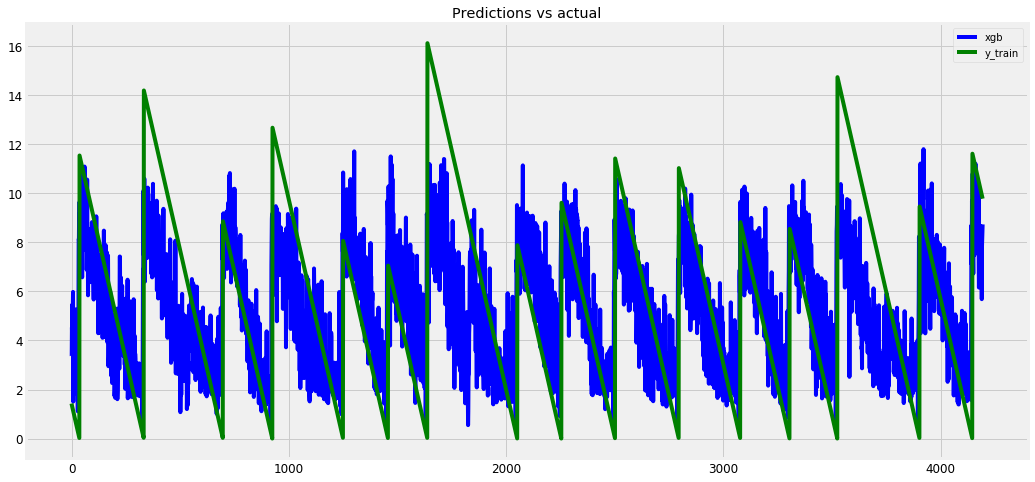

In [22]:
# prediction vs actual
plt.figure(figsize=(16, 8))

plt.plot(oof_xgb, color='blue', label='xgb')
plt.plot(y_tr, color='g', label='y_train')
plt.legend();
plt.title('Predictions vs actual');

error = mae(oof_xgb, y_tr)[0]
print('MAE:', error, 'sec')



# Create submission file for Kaggle competition

In [23]:
submission = pd.read_csv(filepath + 'sample_submission.csv', index_col='seg_id') # take the seg_id
submission['time_to_failure'] = prediction_xgb

submission.to_csv('submission.csv')

submission.head()

,time_to_failure
seg_id,
seg_00030f,5.556111812591553
seg_0012b5,5.412266159057618
seg_00184e,4.586750793457031
seg_003339,7.336558628082275
seg_0042cc,6.653650760650635


In [24]:
submission.shape

(2624, 1)